# Stock Movement Analysis Based on Social Media Sentiment

This project aims to predict stock movement using sentiment analysis of Reddit posts. The process involves scraping Reddit posts, performing sentiment analysis on them, and merging the results with stock price data. The final model will predict stock price trends based on sentiment signals from Reddit discussions.

We will follow these steps:
1. Scrape Reddit data
2. Preprocess the text data
3. Perform sentiment analysis
4. Merge the sentiment data with stock data
5. Analyze the results and build a predictive model

In [ ]:
import praw
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import yfinance as yf
from datetime import datetime

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Initialize Reddit API
def init_reddit():
    reddit = praw.Reddit(
        client_id="qxZ-XdAx-8NEroCUW-SU1Q",
        client_secret="x4ibqgGedEUoEHaZaNeAoONz66X5xA",
        user_agent="stock_sentiment_analysis"
    )
    return reddit

# Scrape Reddit posts from a subreddit
def scrape_reddit(subreddit_name, limit=100):
    reddit = init_reddit()
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for post in subreddit.hot(limit=limit):
        posts.append({
            'title': post.title,
            'selftext': post.selftext,
            'score': post.score,
            'comments': post.num_comments,
            'created_utc': post.created_utc
        })
    return pd.DataFrame(posts)

# Scrape 100 posts from the 'wallstreetbets' subreddit
reddit_data = scrape_reddit('wallstreetbets', limit=100)

# Display the first few rows of the data
reddit_data.head()


,title,selftext,score,comments,created_utc
0,Weekly Earnings Thread 11/25 - 11/29,,200,1446,1.732288e+09
1,"Daily Discussion Thread for November 29, 2024",This post contains content not supported on ol...,21,305,1.732878e+09
2,Lost nearly $2M shorting NVDA this year. Still...,,1188,476,1.732869e+09
3,hope you have a nice day,,4787,196,1.732838e+09
4,Checking my portfolio when I'm out with friends,,19975,437,1.732810e+09


In [5]:
# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply preprocessing to the title and selftext columns
reddit_data['cleaned_text'] = reddit_data['title'].apply(preprocess_text)

# Display the first few rows of the cleaned data
reddit_data[['title', 'cleaned_text']].head()


,title,cleaned_text
0,Weekly Earnings Thread 11/25 - 11/29,weekly earnings thread 1125 1129
1,"Daily Discussion Thread for November 29, 2024",daily discussion thread for november 29 2024
2,Lost nearly $2M shorting NVDA this year. Still...,lost nearly 2m shorting nvda this year still h...
3,hope you have a nice day,hope you have a nice day
4,Checking my portfolio when I'm out with friends,checking my portfolio when im out with friends


In [6]:
# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to analyze sentiment using VADER
def analyze_sentiment(text):
    return sia.polarity_scores(text)['compound']  # Compound score

# Apply sentiment analysis to the cleaned text
reddit_data['sentiment'] = reddit_data['cleaned_text'].apply(analyze_sentiment)

# Display sentiment scores
reddit_data[['title', 'sentiment']].head()


,title,sentiment
0,Weekly Earnings Thread 11/25 - 11/29,0.0000
1,"Daily Discussion Thread for November 29, 2024",0.0000
2,Lost nearly $2M shorting NVDA this year. Still...,-0.3182
3,hope you have a nice day,0.6908
4,Checking my portfolio when I'm out with friends,0.4767


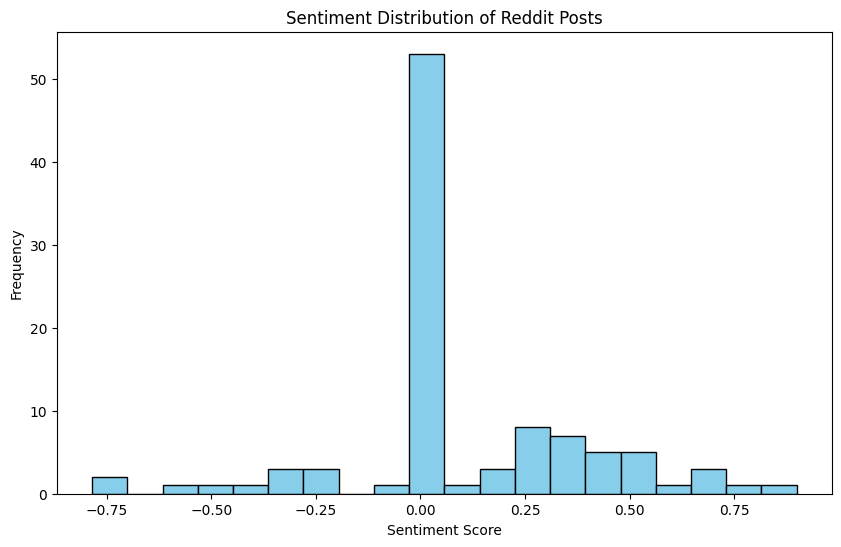

In [7]:
# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
reddit_data['sentiment'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution of Reddit Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Fetch stock data for Apple using yfinance
def get_stock_data(ticker, period="1y"):
    stock = yf.Ticker(ticker)
    stock_data = stock.history(period=period)
    return stock_data

# Fetch Apple stock data
stock_data = get_stock_data('AAPL', period='1y')

# Display the stock data
stock_data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-28 00:00:00-05:00,188.854783,190.148449,188.476631,189.471756,38415400,0.0,0.0
2023-11-29 00:00:00-05:00,189.969332,191.153533,188.048749,188.446793,43014200,0.0,0.0
2023-11-30 00:00:00-05:00,188.914507,189.392178,187.272557,189.023972,48794400,0.0,0.0
2023-12-01 00:00:00-05:00,189.402111,190.626110,188.307468,190.307678,45679300,0.0,0.0
2023-12-04 00:00:00-05:00,189.053822,189.123488,186.536157,188.506500,43389500,0.0,0.0


In [17]:
# Convert 'created_utc' to datetime and extract the date for Reddit data
reddit_data['date'] = pd.to_datetime(reddit_data['created_utc'], unit='s').dt.date

# If 'Date' already exists in stock_data, drop it before resetting the index
if 'Date' in stock_data.columns:
    stock_data = stock_data.drop(columns=['Date'])

# Reset the index of stock_data to expose the date index as a column
stock_data = stock_data.reset_index()

# Convert the stock data 'Date' column (from index) to date format
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge the data on 'date' (Reddit) and 'Date' (Stock)
merged_data = pd.merge(reddit_data, stock_data, left_on='date', right_on='Date', how='inner')

# Display the merged data
print(merged_data.head())



                                       title  \
0       Weekly Earnings Thread 11/25 - 11/29   
1               I have a gambling addiction    
2  Shoutout to Achr guy a few weeks ago +60k   
3                        Am I dreaming $ARCH   
4                  GOING back to my EX, MSTR   

                                            selftext  score  comments  \
0                                                       200      1446   
1  Tried to become a Wall Street millionaire and ...   5433       878   
2  Started with 600 7c for Jan 17th. Started sell...   1907       179   
3                                                       988       170   
4  She did me dirty last time but i still believe...   1365       799   

    created_utc                              cleaned_text  sentiment  \
0  1.732288e+09         weekly earnings thread 1125  1129        0.0   
1  1.732734e+09              i have a gambling addiction         0.0   
2  1.732732e+09  shoutout to achr guy a few weeks ago 60

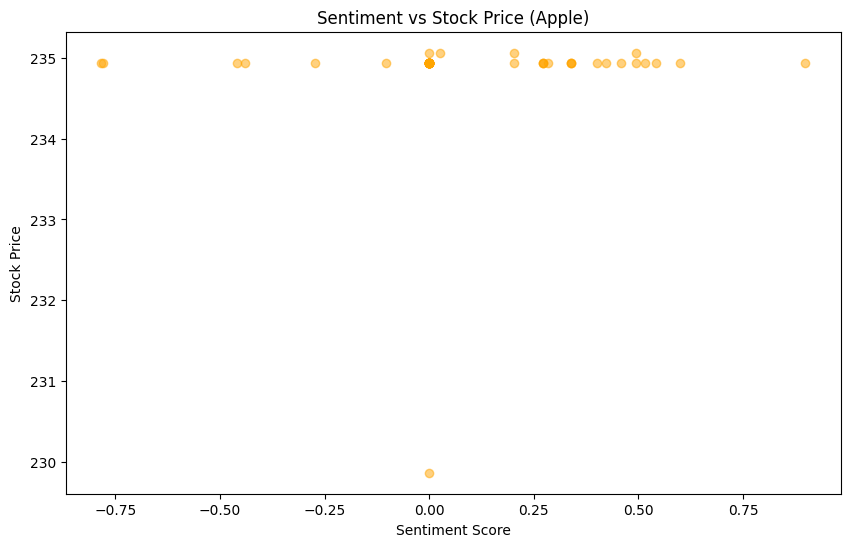

In [18]:
# Plot the relationship between sentiment and stock price
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['sentiment'], merged_data['Close'], alpha=0.5, color='orange')
plt.title('Sentiment vs Stock Price (Apple)')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Price')
plt.show()


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare the features and target variable
X = merged_data[['sentiment']]
y = merged_data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.02834380168574579


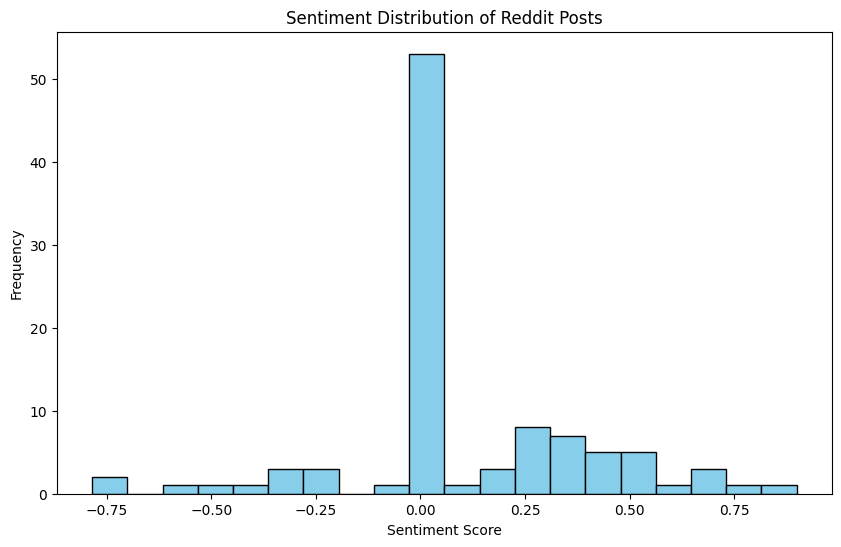

In [20]:
# Sentiment distribution
plt.figure(figsize=(10, 6))
reddit_data['sentiment'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Distribution of Reddit Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


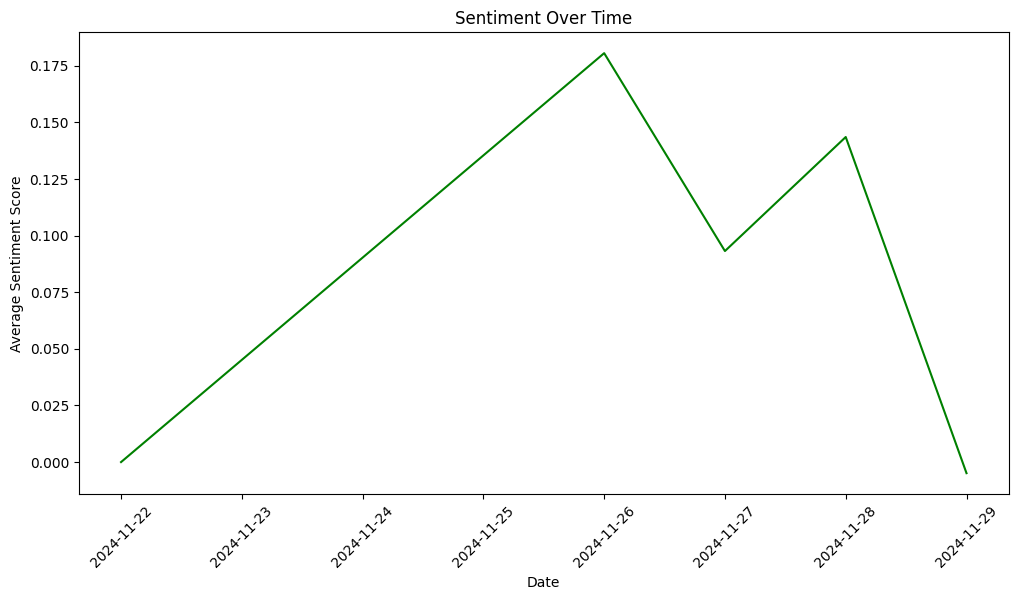

In [21]:
# Plot sentiment over time
reddit_data['date'] = pd.to_datetime(reddit_data['created_utc'], unit='s').dt.date
sentiment_time_series = reddit_data.groupby('date')['sentiment'].mean()

plt.figure(figsize=(12, 6))
plt.plot(sentiment_time_series, color='green')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()


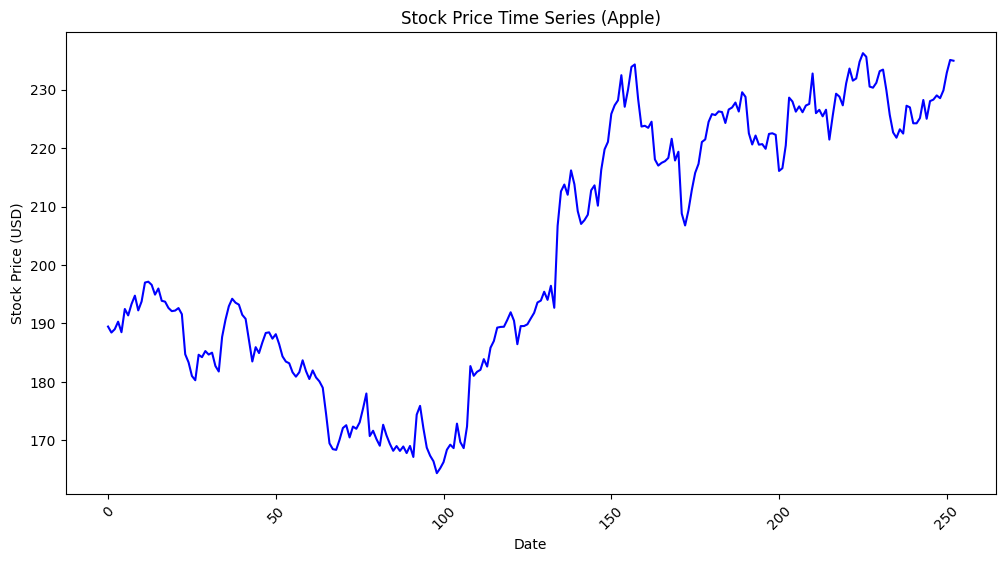

In [22]:
# Stock price time series
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], color='blue')
plt.title('Stock Price Time Series (Apple)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.xticks(rotation=45)
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_25160\2906985284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_movement', y='sentiment', data=merged_data, palette='Set2')


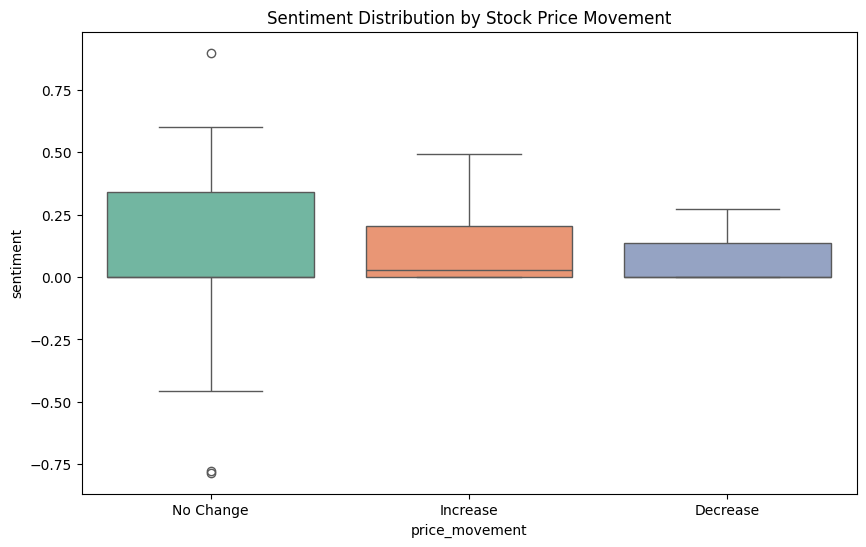

In [26]:
# Create a new column categorizing stock price movement
merged_data['price_movement'] = merged_data['Close'].diff().apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change'))

# Box plot of sentiment by price movement
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_movement', y='sentiment', data=merged_data, palette='Set2')
plt.title('Sentiment Distribution by Stock Price Movement')
plt.show()


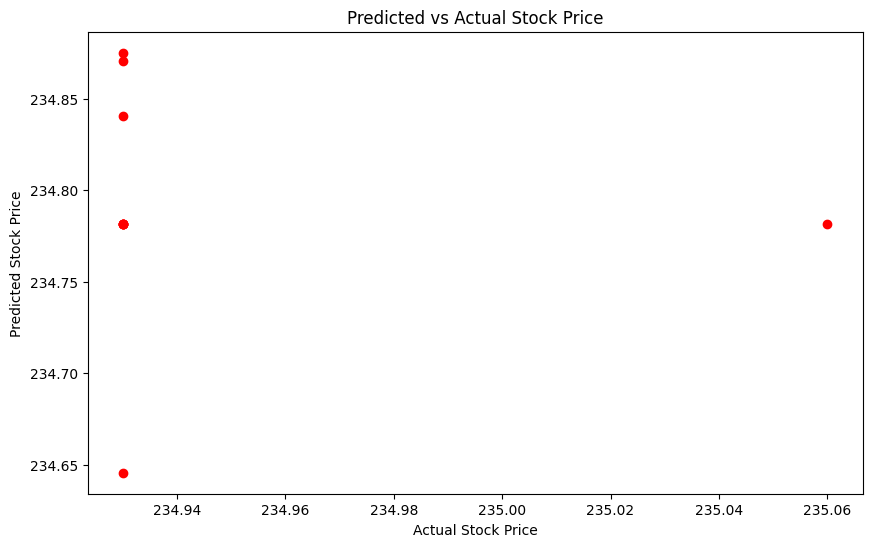

In [30]:
# Predicted vs Actual Stock Price
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='red')
plt.title('Predicted vs Actual Stock Price')
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.show()
